In [0]:
import pandas as pd
import numpy as np
import statsmodels
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima_model import ARIMA
from sklearn.ensemble import RandomForestRegressor

from tqdm import tqdm, tqdm_notebook

import quandl

import warnings
warnings.filterwarnings('ignore')

seed = 10031998

In [0]:
np.random.seed(seed)

In [0]:
def create_lagged_dataset(dataset, lag=1):
    df = pd.DataFrame(dataset)
    for i in range(lag):
        new_feature = df.T.tail(1).T.shift(-1)
        df = pd.concat((df, new_feature), axis=1)
    dataX = df.values[:len(dataset) - lag,:-1]
    dataY = df.values[:len(dataset) - lag,-1]
    return dataX, dataY

In [0]:
# source: https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
# ts_df = quandl.get("FRBP/ROUTPUT_MOSTRECENT", authtoken="MHASo5sqBFCvT5s55CxJ")
ts_df = quandl.get("FRED/DFF", authtoken="MHASo5sqBFCvT5s55CxJ")

In [0]:
ts_df.tail()

,Value
Date,
2019-05-16,2.39
2019-05-17,2.39
2019-05-18,2.39
2019-05-19,2.39
2019-05-20,2.39


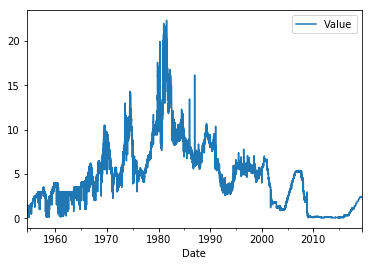

In [0]:
ts_df.plot();

In [0]:
# TOO SLOW !!!


# # for RandomForest
# def validate_gamma(lags, n_splits, ts, gamma_test_part = 6, gammas=[0.3, 0.9, 1]):
#     ts_gamma_train = ts.values[: (gamma_test_part - 1) * int(ts.shape[0] // gamma_test_part)]
#     ts_gamma_test = ts.values[(gamma_test_part - 1) * int(ts.shape[0] // gamma_test_part):]
    
#     res_mape = {}
#     tscv = TimeSeriesSplit(n_splits=n_splits)
#     gammas_best = []
#     i = -1
#     for gamma in gammas:
#         i += 1
#         lowest_mape = 10**10
#         gammas_best.append(-1)
#         for lag in lags:
#             mapes = []
#             for train_index, test_index in tscv.split(ts_gamma_train):
#                 ts_train, ts_test = ts_gamma_train[train_index], ts_gamma_train[test_index]

#                 # train test
#                 X_train, y_train = create_lagged_dataset(ts_train, lag=lag)
#                 X_test, y_test = create_lagged_dataset(ts_test, lag=lag)
#                 model = RandomForestRegressor(random_state=seed)
#                 model.fit(X_train,y_train)
#                 y_hat = model.predict(X_test)

#                 mapes.append(mean_absolute_percentage_error(y_test, y_hat))

            
#             powers = np.arange(len(mapes))[::-1]
#             gammas = np.ones(len(mapes)) * gamma
#             print(np.mean(np.power(gammas, powers) * mapes))
#             res_mape[str(gamma) + "_" + str(lag)] = np.mean(np.power(gammas, powers) * mapes)
#             if np.mean(np.power(gammas, powers) * mapes) < lowest_mape:
#                 gammas_best[i] = lag
#                 lowest_mape = np.mean(np.power(gammas, powers) * mapes)
            
#     mapes_for_gammas = []
#     best_gamma = None
#     if len(np.unique(gammas_best)) == 1:
#         best_gamma = "same_results"
#     else:
#         for gamma_best in gammas_best:
            
#             X_train, y_train = create_lagged_dataset(ts_gamma_train, lag=gamma_best)
#             X_test, y_test = create_lagged_dataset(ts_gamma_test, lag=gamma_best)
#             model = RandomForestRegressor()
#             model.fit(X_train, y_train)
            
#             y_hat = model.predict(X_test)
#             mapes_for_gammas.append(mean_absolute_percentage_error(y_test, y_hat))
        
#         best_gamma = gammas[np.argmin(mapes_for_gammas)]
            
#     return res_mape , gammas_best , best_gamma
            
    
            

In [57]:
np.arange(0, 1, 0.02)

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98])

In [0]:
# for RandomForest

def validate_gamma(lags, n_splits, ts, gamma_test_part = 6, gammas=np.arange(0, 1.02, 0.02)):
    ts_gamma_train = ts.values[: (gamma_test_part - 1) * int(ts.shape[0] // gamma_test_part)]
    ts_gamma_test = ts.values[(gamma_test_part - 1) * int(ts.shape[0] // gamma_test_part):]
    
    res_mape = {}
    tscv = TimeSeriesSplit(n_splits=n_splits)
    gammas_best = []
    i = -1

    for lag in lags:
        mapes = []
        for train_index, test_index in tscv.split(ts_gamma_train):
            ts_train, ts_test = ts_gamma_train[train_index], ts_gamma_train[test_index]

            # train test
            X_train, y_train = create_lagged_dataset(ts_train, lag=lag)
            X_test, y_test = create_lagged_dataset(ts_test, lag=lag)
            model = RandomForestRegressor(random_state=seed)
            model.fit(X_train,y_train)
            y_hat = model.predict(X_test)

            mapes.append(mean_absolute_percentage_error(y_test, y_hat))


        for gamma in gammas:
            powers = np.arange(len(mapes))[::-1]
            gammas_pow = np.ones(len(mapes)) * gamma
            res_mape[str(gamma) + "_" + str(lag)] = np.mean(np.power(gammas_pow, powers) * mapes)
            
#     print(res_mape)
    i = -1
    for gamma in gammas:
        i += 1
        lowest_mape = 10**10
        gammas_best.append(-1)
        for lag in lags:
            if res_mape[str(gamma) + "_" + str(lag)] < lowest_mape:
                lowest_mape = res_mape[str(gamma) + "_" + str(lag)]
                gammas_best[i] = lag
            
            
    mapes_for_gammas = []
    best_gamma = None
    if len(np.unique(gammas_best)) == 1:
        best_gamma = "same_results_all_models"
    else:
        for gamma_best in gammas_best:
            X_train, y_train = create_lagged_dataset(ts_gamma_train, lag=gamma_best)
            X_test, y_test = create_lagged_dataset(ts_gamma_test, lag=gamma_best)
            model = RandomForestRegressor()
            model.fit(X_train, y_train)
            
            y_hat = model.predict(X_test)
            mapes_for_gammas.append(mean_absolute_percentage_error(y_test, y_hat))
        
        best_gamma = gammas[np.argmin(mapes_for_gammas)]
    
    if best_gamma != "same_results_all_models":
        if gammas_best[np.argmin(mapes_for_gammas)] == gammas_best[-1]:
            best_gamma = "gamma_1_is_ok"
    return res_mape , gammas_best , best_gamma
            
    
            

In [59]:
validate_gamma([1,2,3], 5, ts_df)

({'0.02_1': 1.1323763401464961,
  '0.02_2': 0.5663373817276892,
  '0.02_3': 0.8696169231903532,
  '0.04_1': 1.1522043830515898,
  '0.04_2': 0.5849596458289202,
  '0.04_3': 0.8847920364928546,
  '0.06_1': 1.1727430806078436,
  '0.06_2': 0.6042322416941504,
  '0.06_3': 0.9006605400927267,
  '0.08_1': 1.1941215413056279,
  '0.08_2': 0.6242912339550419,
  '0.08_3': 0.9173769346611522,
  '0.0_1': 1.1131458312082931,
  '0.0_2': 0.5482453820986224,
  '0.0_3': 0.8549967283210831,
  '0.12_1': 1.2399941251177697,
  '0.12_2': 0.6673926528895965,
  '0.12_3': 0.9540515434236119,
  '0.14_1': 1.2648264042433701,
  '0.14_2': 0.6907871955257209,
  '0.14_3': 0.9743989029952287,
  '0.16_1': 1.2911747585329856,
  '0.16_2': 0.71567236648243,
  '0.16_3': 0.9963724442905646,
  '0.18_1': 1.319248235507489,
  '0.18_2': 0.7422642170905228,
  '0.18_3': 1.0202068120160193,
  '0.1_1': 1.216484861441413,
  '0.1_2': 0.645288684583085,
  '0.1_3': 0.9351117496763572,
  '0.22_1': 1.3814866866251525,
  '0.22_2': 0.80151

In [0]:
# M4 competition
df = pd.read_csv("Monthly-train.csv")

In [0]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,...,V2756,V2757,V2758,V2759,V2760,V2761,V2762,V2763,V2764,V2765,V2766,V2767,V2768,V2769,V2770,V2771,V2772,V2773,V2774,V2775,V2776,V2777,V2778,V2779,V2780,V2781,V2782,V2783,V2784,V2785,V2786,V2787,V2788,V2789,V2790,V2791,V2792,V2793,V2794,V2795
0,M1,8000.0,8350.0,8570.0,7700.0,7080.0,6520.0,6070.0,6650.0,6830.0,5710.0,5260.0,5470.0,7870.0,7360.0,8470.0,7880.0,6750.0,6860.0,6220.0,6650.0,5450.0,5280.0,4970.0,5550.0,7750.0,7760.0,7190.0,7440.0,6590.0,6210.0,6010.0,6390.0,5780.0,5700.0,4680.0,4970.0,6850.0,6740.0,7490.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M2,2440.0,2490.0,2710.0,2290.0,1960.0,1990.0,1960.0,2530.0,2640.0,2650.0,2150.0,1910.0,2510.0,2100.0,1840.0,2330.0,1830.0,2290.0,2090.0,2340.0,2420.0,1850.0,1960.0,2000.0,2300.0,2160.0,1730.0,2090.0,1890.0,2180.0,1950.0,2020.0,1770.0,1960.0,1860.0,1340.0,2150.0,2180.0,2030.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M3,2670.0,2590.0,2784.0,2816.0,2888.0,2906.0,2839.0,2860.0,2798.0,2795.0,2796.0,2858.0,2782.0,2801.0,2907.0,2919.0,2937.0,2878.0,2841.0,2967.0,3050.0,2981.0,3076.0,3033.0,2936.0,2927.0,2929.0,2987.0,2777.0,2760.0,2769.0,2830.0,2861.0,2991.0,3063.0,3134.0,3020.0,2947.0,3026.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,M4,7264.0,7215.0,7022.0,7040.0,6966.0,6984.0,7025.0,7082.0,6956.0,7014.0,7067.0,7099.0,7046.0,7139.0,7011.0,7022.0,7084.0,7036.0,7098.0,7083.0,7045.0,7057.0,6986.0,6937.0,6927.0,6953.0,7007.0,6949.0,6930.0,6925.0,6956.0,6946.0,6866.0,6814.0,6806.0,6806.0,6855.0,6951.0,6898.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M5,4210.0,4290.0,4250.0,4320.0,4320.0,4330.0,4320.0,4260.0,4220.0,4260.0,4180.0,4230.0,4270.0,4500.0,4410.0,4440.0,4430.0,4440.0,4540.0,4450.0,4420.0,4410.0,4300.0,4300.0,4420.0,4350.0,4340.0,4410.0,4340.0,4400.0,4360.0,4420.0,4470.0,4310.0,4280.0,4220.0,4190.0,4120.0,4150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


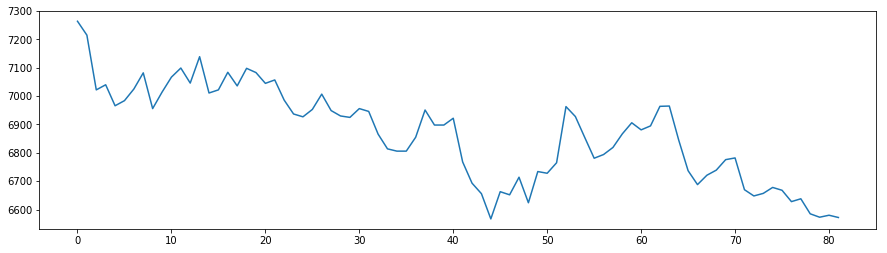

In [60]:
plt.figure(figsize=(15,4))
x = df[3:4].values[0][1:]
x = np.array(x, dtype=float)
x = x[~np.isnan(x)]
plt.plot(x);

In [61]:
validate_gamma(np.arange(1, x.shape[0] // 10, 4), 5, pd.DataFrame(x))

({'0.02_1': 0.13784813685365183,
  '0.02_5': 0.16633952638713087,
  '0.04_1': 0.14314882762385,
  '0.04_5': 0.1734082147357666,
  '0.06_1': 0.14873343358723637,
  '0.06_5': 0.1808686748796256,
  '0.08_1': 0.1546132769462239,
  '0.08_5': 0.1887408466623785,
  '0.0_1': 0.13282067553094756,
  '0.0_5': 0.1596432904966885,
  '0.12_1': 0.16730714694424847,
  '0.12_5': 0.2058031870524518,
  '0.14_1': 0.17414700027170543,
  '0.14_5': 0.21503633788031679,
  '0.16_1': 0.18133374437160338,
  '0.16_5': 0.22476716478816489,
  '0.18_1': 0.18888188372994927,
  '0.18_5': 0.23501871015286993,
  '0.1_1': 0.16080031635994443,
  '0.1_5': 0.19704529043433658,
  '0.22_1': 0.2051235484496062,
  '0.22_5': 0.2571792282935504,
  '0.24_1': 0.21384926506652496,
  '0.24_5': 0.26913738835647694,
  '0.26_1': 0.22300075945310693,
  '0.26_5': 0.28171464145016306,
  '0.28_1': 0.23259571837895293,
  '0.28_5': 0.294937132484686,
  '0.2_1': 0.19680655928946875,
  '0.2_5': 0.24581463685794666,
  '0.32_1': 0.253189959210433

In [62]:
hist = []
for i in tqdm_notebook(np.random.choice(47998, size = 2000)):
    x = df[i:i+1].values[0][1:]
    x = np.array(x, dtype=float)
    x = x[~np.isnan(x)] 
    _, _, best_gamma = validate_gamma(np.arange(1, x.shape[0] // 10, 5), 6, pd.DataFrame(x))
    hist.append(best_gamma)

In [0]:
unique, counts = np.unique(hist, return_counts = True)

In [0]:
result = list(zip(unique, counts))

In [65]:
result

[('0.0', 32),
 ('0.02', 24),
 ('0.04', 28),
 ('0.06', 25),
 ('0.08', 12),
 ('0.1', 15),
 ('0.12', 17),
 ('0.14', 18),
 ('0.16', 17),
 ('0.18', 22),
 ('0.2', 18),
 ('0.22', 13),
 ('0.24', 12),
 ('0.26', 8),
 ('0.28', 11),
 ('0.3', 15),
 ('0.32', 10),
 ('0.34', 7),
 ('0.36', 9),
 ('0.38', 12),
 ('0.4', 10),
 ('0.42', 9),
 ('0.44', 7),
 ('0.46', 6),
 ('0.48', 14),
 ('0.5', 6),
 ('0.52', 9),
 ('0.54', 9),
 ('0.56', 4),
 ('0.58', 1),
 ('0.6', 7),
 ('0.62', 8),
 ('0.64', 2),
 ('0.66', 5),
 ('0.68', 2),
 ('0.7000000000000001', 4),
 ('0.72', 4),
 ('0.74', 3),
 ('0.76', 3),
 ('0.78', 1),
 ('0.8', 1),
 ('0.84', 2),
 ('0.86', 1),
 ('0.9', 4),
 ('0.92', 3),
 ('0.96', 3),
 ('gamma_1_is_ok', 406),
 ('same_results_all_models', 1141)]

In [0]:
gammas_victory = 0
for i in range(len(result) - 2):
  gammas_victory += result[i][1]

In [0]:
x = ["gamma_victory", "gamma_1_is_ok", "same_results_all_models"]
y = []
y.append(gammas_victory)
y += counts[-3:]

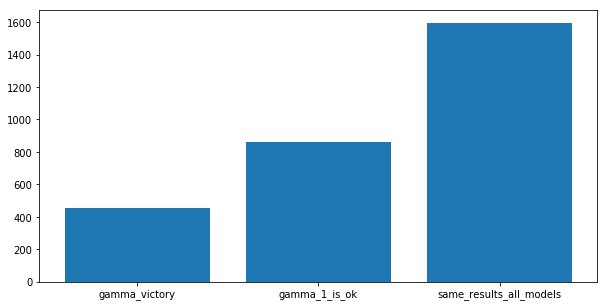

In [68]:
plt.figure(figsize=(10,5))
plt.bar(x, y);

In [70]:
y

array([ 456,  859, 1594])